<a href="https://colab.research.google.com/github/ephantusGachomba/AutoInland_Vehicle_Insurance_Claim_Challenge/blob/main/AutoInland_Vehicle_Insurance_Claim_Challenge_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Step 1 - Preliminaries

## Imports and Configuration

In [ ]:
#Basic libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

#Handling missing values
from sklearn.impute import SimpleImputer

#Normalization and Standardization
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA 

#Feature 
from sklearn.linear_model import Lasso

#Onehot encoding
from sklearn.preprocessing import OneHotEncoder

#Grid search cv
from sklearn.model_selection import GridSearchCV

#Models
from lightgbm import LGBMClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LinearRegression, LogisticRegressionCV, ElasticNet
from sklearn.preprocessing import PolynomialFeatures
from sklearn.neural_network import MLPClassifier

#metrics
from sklearn.metrics import f1_score, mean_squared_error, accuracy_score, confusion_matrix

import warnings
warnings.filterwarnings('ignore')

# Reading Files

In [ ]:
#Load data into pandas dataframe
train = pd.read_csv("Train.csv")
test = pd.read_csv("Test.csv")
ss = pd.read_csv("SampleSubmission.csv")

In [ ]:
# Preview the first five rows of the train set
train.head()

,ID,Policy Start Date,Policy End Date,Gender,Age,First Transaction Date,No_Pol,Car_Category,Subject_Car_Colour,Subject_Car_Make,LGA_Name,State,ProductName,target
0,ID_0040R73,2010-05-14,2011-05-13,Male,30,2010-05-14,1,Saloon,Black,TOYOTA,NaN,NaN,Car Classic,0
1,ID_0046BNK,2010-11-29,2011-11-28,Female,79,2010-11-29,1,JEEP,Grey,TOYOTA,NaN,NaN,Car Classic,1
2,ID_005QMC3,2010-03-21,2011-03-20,Male,43,2010-03-21,1,Saloon,Red,TOYOTA,NaN,NaN,Car Classic,0
3,ID_0079OHW,2010-08-21,2011-08-20,Male,2,2010-08-21,1,NaN,NaN,NaN,NaN,NaN,CarSafe,0
4,ID_00BRP63,2010-08-29,2010-12-31,Entity,20,2010-08-29,3,NaN,NaN,NaN,Lagos,Lagos,Muuve,1


In [ ]:
# Preview the first five rows of the test set
test.head()

,ID,Policy Start Date,Policy End Date,Gender,Age,First Transaction Date,No_Pol,Car_Category,Subject_Car_Colour,Subject_Car_Make,LGA_Name,State,ProductName
0,ID_01QM0NU,2010-10-23,2011-10-22,Female,46,2010-10-23,1,NaN,NaN,Ford,Abuja Municipal,Abuja-Municipal,Car Classic
1,ID_024NJLZ,2010-10-14,2011-10-13,Male,32,2010-10-14,1,NaN,NaN,NaN,Kosofe,Benue,Car Classic
2,ID_02NOVWQ,2010-08-29,2011-08-28,Female,45,2010-08-29,2,Saloon,Black,Honda,Wuse 11,Abuja,Car Classic
3,ID_02VSP68,2010-06-13,2011-06-12,Female,58,2010-06-13,1,Saloon,NaN,TOYOTA,NaN,NaN,CarSafe
4,ID_02YB37K,2010-07-01,2011-06-30,NaN,120,2010-07-01,1,Saloon,Red,Hyundai,Victoria Island,Lagos,Car Classic


In [ ]:
# Preview the first five rows of the sample submission file
ss.head()

,ID,target
0,ID_01QM0NU,0
1,ID_024NJLZ,0
2,ID_02NOVWQ,0
3,ID_02VSP68,0
4,ID_02YB37K,0


In [ ]:
# Check the shape of the train and test sets
print(f'The shape of the train set is: {train.shape}\nThe shape of the test set is: {test.shape}')

The shape of the train set is: (12079, 14)
The shape of the test set is: (1202, 13)


## Data Preprocessing

In [ ]:
#Combine train and test dataset
ntrain = train.shape[0] # to be used to split train and test set from the combined dataframe

all_data = pd.concat((train, test)).reset_index(drop=True)
print(f'The shape of the combined dataframe is: {all_data.shape}')

The shape of the combined dataframe is: (13281, 14)


In [ ]:
print(train.shape)
print(test.shape)

(12079, 14)
(1202, 13)


### Clean Data

In [ ]:
# Check the column names and datatypes
all_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13281 entries, 0 to 13280
Data columns (total 14 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   ID                      13281 non-null  object 
 1   Policy Start Date       13281 non-null  object 
 2   Policy End Date         13281 non-null  object 
 3   Gender                  12881 non-null  object 
 4   Age                     13281 non-null  int64  
 5   First Transaction Date  13281 non-null  object 
 6   No_Pol                  13281 non-null  int64  
 7   Car_Category            9171 non-null   object 
 8   Subject_Car_Colour      5622 non-null   object 
 9   Subject_Car_Make        10557 non-null  object 
 10  LGA_Name                6149 non-null   object 
 11  State                   6137 non-null   object 
 12  ProductName             13281 non-null  object 
 13  target                  12079 non-null  float64
dtypes: float64(1), int64(2), object(11)
me

In [ ]:
#Changing each column to appropriate datatype
date_cols = [col for col in all_data.columns if 'Date' in col]
num_cols = ['Age', 'No_Pol']
cat_cols = [col for col in all_data.columns if col not in date_cols+num_cols+['ID','target']]

for col in all_data.columns:
  if col in date_cols:
    all_data[col] = pd.to_datetime(all_data[col])
  elif col in cat_cols:
    all_data[col] = all_data[col].astype('category')

#Confirming wether the changes have been applied
all_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13281 entries, 0 to 13280
Data columns (total 14 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   ID                      13281 non-null  object        
 1   Policy Start Date       13281 non-null  datetime64[ns]
 2   Policy End Date         13281 non-null  datetime64[ns]
 3   Gender                  12881 non-null  category      
 4   Age                     13281 non-null  int64         
 5   First Transaction Date  13281 non-null  datetime64[ns]
 6   No_Pol                  13281 non-null  int64         
 7   Car_Category            9171 non-null   category      
 8   Subject_Car_Colour      5622 non-null   category      
 9   Subject_Car_Make        10557 non-null  category      
 10  LGA_Name                6149 non-null   category      
 11  State                   6137 non-null   category      
 12  ProductName             13281 non-null  catego

In [ ]:
mapper = {'Entity':'Other', 'Joint Gender':'Other', 'NOT STATED':'Other', 'NO GENDER': 'Other', 'SEX':"Other"}
all_data.Gender = all_data.Gender.replace(mapper)

#Confirm mappings
all_data.Gender.value_counts()

Male      8356
Female    3679
Other      846
Name: Gender, dtype: int64

In [ ]:
for col in all_data[cat_cols]:
  print(f'{col}')
  print(all_data[col].nunique())
  print(all_data[col].unique())

Gender
3
['Male' 'Female' 'Other' nan]
Car_Category
16
['Saloon', 'JEEP', NaN, 'Motorcycle', 'Truck', ..., 'Wagon', 'Shape Of Vehicle Chasis', 'Sedan', 'Station 4 Wheel', 'Tipper Truck']
Length: 17
Categories (16, object): ['Saloon', 'JEEP', 'Motorcycle', 'Truck', ..., 'Shape Of Vehicle Chasis',
                          'Sedan', 'Station 4 Wheel', 'Tipper Truck']
Subject_Car_Colour
46
['Black', 'Grey', 'Red', NaN, 'As Attached', ..., 'Yellow & White', 'Beige Mitalic', 'Light Gray', 'Blue Sky', 'Red Maroon']
Length: 47
Categories (46, object): ['Black', 'Grey', 'Red', 'As Attached', ..., 'Beige Mitalic',
                          'Light Gray', 'Blue Sky', 'Red Maroon']
Subject_Car_Make
75
['TOYOTA', NaN, 'REXTON', 'Lexus', 'Hyundai', ..., 'BRILLIANCE', 'Buik', 'COMMANDER', 'Bajaj', 'Datsun']
Length: 76
Categories (75, object): ['TOYOTA', 'REXTON', 'Lexus', 'Hyundai', ..., 'Buik', 'COMMANDER', 'Bajaj',
                          'Datsun']
LGA_Name
270
[NaN, 'Lagos', 'Ikeja', 'Badagry', '

In [ ]:
all_data['Subject_Car_Make'].value_counts().sort_values(ascending=True).head(60)

Jincheng           1
BRILLIANCE         1
ABG                1
Bajaj              1
COMMANDER          1
CHANGAN            1
Ashok Leyland      1
ZOYTE              1
Caddillac          1
Datsun             1
Buik               1
Howo               1
Geely              1
Rols Royce         1
Raston             1
REXTON             1
Tata               1
MG                 1
Lincoln            1
KA                 1
Yamaha             1
Motorcycle         1
Seat               2
Wrangler Jeep      2
Chrysler           2
Astra              2
FOTON              2
Innson             2
Black              2
Hummer             2
Fiat               2
Grand Cherokee     2
Jaguar             4
LIBERTY            5
Man                5
MINI COOPER        5
GAC                5
Renault            6
Subaru             6
Land Rover.        6
GMC                6
Dodge              7
Isuzu              8
Opel               8
Suzuki             9
Scania            12
As Attached       14
Porsche      

In [ ]:
all_data['Subject_Car_Make'].replace({'.':np.nan}, inplace=True)

In [ ]:
all_data['Subject_Car_Make'].replace({'As Attached':np.nan}, inplace=True)

In [ ]:
all_data.isnull().sum()

ID                           0
Policy Start Date            0
Policy End Date              0
Gender                     400
Age                          0
First Transaction Date       0
No_Pol                       0
Car_Category              4110
Subject_Car_Colour        7659
Subject_Car_Make          2785
LGA_Name                  7132
State                     7144
ProductName                  0
target                    1202
dtype: int64

## Handle Missing Values

In [ ]:
all_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13281 entries, 0 to 13280
Data columns (total 14 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   ID                      13281 non-null  object        
 1   Policy Start Date       13281 non-null  datetime64[ns]
 2   Policy End Date         13281 non-null  datetime64[ns]
 3   Gender                  12881 non-null  object        
 4   Age                     13281 non-null  int64         
 5   First Transaction Date  13281 non-null  datetime64[ns]
 6   No_Pol                  13281 non-null  int64         
 7   Car_Category            9171 non-null   category      
 8   Subject_Car_Colour      5622 non-null   category      
 9   Subject_Car_Make        10496 non-null  object        
 10  LGA_Name                6149 non-null   category      
 11  State                   6137 non-null   category      
 12  ProductName             13281 non-null  catego

#### Cleaning the ages column

In [ ]:
all_data['Age'].describe().transpose()

count    13281.000000
mean        42.375574
std         93.170951
min      -6099.000000
25%         35.000000
50%         41.000000
75%         50.000000
max        320.000000
Name: Age, dtype: float64

In [ ]:
all_data[all_data['Age']<0]

,ID,Policy Start Date,Policy End Date,Gender,Age,First Transaction Date,No_Pol,Car_Category,Subject_Car_Colour,Subject_Car_Make,LGA_Name,State,ProductName,target
909,ID_2SKRJKI,2010-04-30,2011-04-29,Female,-76,2010-04-30,2,NaN,White,Hyundai,Ilupeju,Lagos,CVTP,0.0
1226,ID_3QOZW9J,2010-03-15,2011-03-14,Male,-2,2010-03-15,1,Saloon,Black,TOYOTA,Ibadan South East,Ibadan-East,Customized Motor,0.0
2580,ID_7OMERTL,2010-04-23,2011-04-22,Male,-12,2010-04-23,3,Saloon,As Attached,Hyundai,Victoria Island,Lagos,Car Plus,0.0
3114,ID_98EVCPR,2010-06-26,2011-06-25,Female,-2,2010-06-26,1,JEEP,NaN,TOYOTA,NaN,NaN,Car Classic,0.0
3427,ID_A3YN75Z,2010-10-02,2011-10-01,Other,-6099,2010-10-02,1,NaN,NaN,NaN,NaN,NaN,CarSafe,0.0
3518,ID_AE3U4I4,2010-01-16,2011-01-15,Female,-5939,2010-01-16,2,NaN,As Attached,TOYOTA,Victoria Island,Lagos,Car Classic,1.0
3649,ID_AUPXOA1,2010-08-04,2011-08-03,Male,-22,2010-08-04,1,Saloon,NaN,Mercedes,Oshodi-Isolo,Oshodi-Isolo,CarSafe,0.0
5173,ID_FKJFVMX,2010-12-14,2011-01-13,Female,-5939,2010-12-14,2,NaN,NaN,NaN,Victoria Island,Lagos,Customized Motor,1.0
6387,ID_J0OJ082,2010-04-23,2011-04-22,Male,-12,2010-04-23,3,Saloon,NaN,Hyundai,Victoria Island,Lagos,Car Plus,0.0
6856,ID_KK04G4Y,2010-04-30,2011-04-29,Female,-76,2010-04-30,2,NaN,NaN,Hyundai,Ilupeju,Lagos,CVTP,0.0


In [ ]:
#making the values of the age to be absolute
all_data['Age'] = all_data['Age'].abs()

In [ ]:
#Rechecking the range for the age
all_data.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Age,13281.0,45.148106,91.859380,0.0,35.0,41.0,50.0,6099.0
No_Pol,13281.0,1.302763,0.723195,1.0,1.0,1.0,1.0,10.0
target,12079.0,0.120457,0.325509,0.0,0.0,0.0,0.0,1.0


In [ ]:
all_data[all_data['Age']>144]

,ID,Policy Start Date,Policy End Date,Gender,Age,First Transaction Date,No_Pol,Car_Category,Subject_Car_Colour,Subject_Car_Make,LGA_Name,State,ProductName,target
2487,ID_7EU42FJ,2010-01-29,2011-01-28,Male,320,2010-01-29,2,NaN,NaN,TOYOTA,Abuja,Abuja,Car Classic,0.0
3427,ID_A3YN75Z,2010-10-02,2011-10-01,Other,6099,2010-10-02,1,NaN,NaN,NaN,NaN,NaN,CarSafe,0.0
3493,ID_ABN28TN,2010-09-06,2011-09-05,Male,320,2010-09-06,1,NaN,NaN,Range Rover,Ketu,Lagos,Car Classic,0.0
3518,ID_AE3U4I4,2010-01-16,2011-01-15,Female,5939,2010-01-16,2,NaN,As Attached,TOYOTA,Victoria Island,Lagos,Car Classic,1.0
4511,ID_DJ2OITJ,2010-09-06,2011-09-05,Male,320,2010-09-06,1,NaN,As Attached,Range Rover,Ketu,Lagos,Car Classic,0.0
4969,ID_EXEIEJM,2010-03-25,2011-03-24,Male,320,2010-03-25,2,JEEP,Silver,Range Rover,Victoria Island,Lagos,Car Classic,0.0
4975,ID_EY7TG7T,2010-11-26,2011-11-25,Male,320,2010-11-26,1,NaN,NaN,NaN,Ketu,Lagos,Car Classic,0.0
5173,ID_FKJFVMX,2010-12-14,2011-01-13,Female,5939,2010-12-14,2,NaN,NaN,NaN,Victoria Island,Lagos,Customized Motor,1.0
5730,ID_H6FN9MZ,2010-01-22,2011-01-21,Male,320,2010-01-22,2,NaN,NaN,Honda,Lagos Mainland,Lagos,Car Classic,0.0
5885,ID_HNBGWO8,2010-09-01,2011-08-31,Male,320,2010-09-01,1,NaN,NaN,TOYOTA,Festac,Benue,Car Classic,0.0


In [ ]:
#It seems a common error on 320, 5939, 6099 years
#we replace 320 to 32, 5939 to 59, 6099 to 60
all_data['Age'].replace({320:32, 5939:59, 6099:60}, inplace=True)

In [ ]:
#Rechecking the range for the age
all_data['Age'].describe().transpose()

count    13281.000000
mean        43.547700
std         19.397184
min          0.000000
25%         35.000000
50%         41.000000
75%         50.000000
max        144.000000
Name: Age, dtype: float64

In [ ]:
all_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13281 entries, 0 to 13280
Data columns (total 14 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   ID                      13281 non-null  object        
 1   Policy Start Date       13281 non-null  datetime64[ns]
 2   Policy End Date         13281 non-null  datetime64[ns]
 3   Gender                  12881 non-null  object        
 4   Age                     13281 non-null  int64         
 5   First Transaction Date  13281 non-null  datetime64[ns]
 6   No_Pol                  13281 non-null  int64         
 7   Car_Category            9171 non-null   category      
 8   Subject_Car_Colour      5622 non-null   category      
 9   Subject_Car_Make        10496 non-null  object        
 10  LGA_Name                6149 non-null   category      
 11  State                   6137 non-null   category      
 12  ProductName             13281 non-null  catego

#### filling null values in gender column

In [ ]:
all_data.isnull().sum()

ID                           0
Policy Start Date            0
Policy End Date              0
Gender                     400
Age                          0
First Transaction Date       0
No_Pol                       0
Car_Category              4110
Subject_Car_Colour        7659
Subject_Car_Make          2785
LGA_Name                  7132
State                     7144
ProductName                  0
target                    1202
dtype: int64

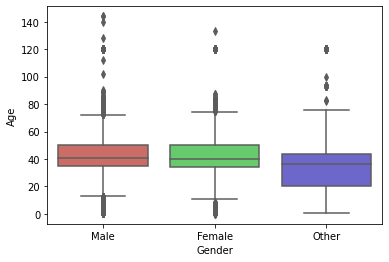

In [ ]:
#Check relation of gender to age
sns.boxplot(x='Gender', y='Age', data=all_data, palette='hls')

In [ ]:
all_data[all_data['Gender'].isnull()].head()

,ID,Policy Start Date,Policy End Date,Gender,Age,First Transaction Date,No_Pol,Car_Category,Subject_Car_Colour,Subject_Car_Make,LGA_Name,State,ProductName,target
32,ID_02XA0UK,2010-10-07,2011-04-05,NaN,34,2010-10-07,1,NaN,NaN,NaN,Victoria Island,Lagos,Car Classic,0.0
33,ID_034XN1U,2010-07-02,2011-07-01,NaN,2,2010-07-02,1,Motorcycle,Red,Jincheng,Victoria Island,Lagos,Motor Cycle,0.0
38,ID_03O8OI6,2010-05-08,2011-05-07,NaN,120,2010-05-08,2,JEEP,As Attached,TOYOTA,Victoria Island,Lagos,Car Classic,0.0
54,ID_058YC0S,2010-11-28,2011-11-27,NaN,120,2010-11-28,1,JEEP,Black,Lexus,Victoria Island,Lagos,Customized Motor,0.0
72,ID_070SYAE,2010-04-17,2011-04-16,NaN,120,2010-04-17,1,JEEP,Silver,Lexus,Victoria Island,Lagos,Customized Motor,0.0


In [ ]:
#A function that finds null values in gender and replaces with respect to age
def gender_approx(cols):
  Age = cols[0]
  Gender = cols[1]

  if pd.isnull(Gender):
    if Age >= 70  :
      return "Male"
    elif Age < 30 and Age > 20:
      return "Other"
    elif Age > 40 and Age < 70:
      return "Female"
    else:
      return "Male"

  else:
    return Gender

In [ ]:
#Apply function and check for null values
all_data['Gender'] = all_data[['Age', 'Gender']].apply(gender_approx, axis=1)
all_data.isnull().sum()

ID                           0
Policy Start Date            0
Policy End Date              0
Gender                       0
Age                          0
First Transaction Date       0
No_Pol                       0
Car_Category              4110
Subject_Car_Colour        7659
Subject_Car_Make          2785
LGA_Name                  7132
State                     7144
ProductName                  0
target                    1202
dtype: int64

In [ ]:
all_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13281 entries, 0 to 13280
Data columns (total 14 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   ID                      13281 non-null  object        
 1   Policy Start Date       13281 non-null  datetime64[ns]
 2   Policy End Date         13281 non-null  datetime64[ns]
 3   Gender                  13281 non-null  object        
 4   Age                     13281 non-null  int64         
 5   First Transaction Date  13281 non-null  datetime64[ns]
 6   No_Pol                  13281 non-null  int64         
 7   Car_Category            9171 non-null   category      
 8   Subject_Car_Colour      5622 non-null   category      
 9   Subject_Car_Make        10496 non-null  object        
 10  LGA_Name                6149 non-null   category      
 11  State                   6137 non-null   category      
 12  ProductName             13281 non-null  catego

#### filling null values in Subject_Car_Make

In [ ]:
all_data['Subject_Car_Make'].value_counts().sort_values(ascending=False).head(60)

TOYOTA            5466
Honda             1146
Lexus              654
Mercedes           577
Hyundai            512
Kia                375
Ford               307
Nissan             275
Volkswagen         133
Iveco              129
Range Rover        121
Mitsubishi         102
ACURA               69
BMW                 68
Land Rover          66
Mazda               47
Peugeot             47
Volvo               43
Mack                35
Audi                33
Infiniti            30
Pontiac             29
Chevrolet           26
DAF                 21
Skoda               18
Jeep                17
Porsche             16
Scania              12
Suzuki               9
Opel                 8
Isuzu                8
Dodge                7
Land Rover.          6
GMC                  6
Renault              6
Subaru               6
MINI COOPER          5
Man                  5
LIBERTY              5
GAC                  5
Jaguar               4
Innson               2
Black                2
Wrangler Je

In [ ]:
all_data['Subject_Car_Make'].unique()

array(['TOYOTA', nan, 'REXTON', 'Lexus', 'Hyundai', 'Iveco', 'DAF',
       'Honda', 'Mercedes', 'Jincheng', 'ACURA', 'Ford', 'Volkswagen',
       'Nissan', 'Pontiac', 'Range Rover', 'Kia', 'Mitsubishi', 'Scania',
       'BMW', 'Infiniti', 'Renault', 'Volvo', 'Hummer', 'Mack',
       'Grand Cherokee', 'Porsche', 'Peugeot', 'Land Rover', 'Chevrolet',
       'Mazda', 'Man', 'Jeep', 'Audi', 'Suzuki', 'MINI COOPER', 'KA',
       'Innson', 'Isuzu', 'Skoda', 'Jaguar', 'Chrysler', 'Dodge', 'GMC',
       'Land Rover.', 'Subaru', 'GAC', 'Fiat', 'Opel', 'Astra',
       'Motorcycle', 'ZOYTE', 'Seat', 'FOTON', 'Howo', 'Lincoln',
       'Rols Royce', 'CHANGAN', 'LIBERTY', 'ABG', 'Yamaha', 'Black',
       'Tata', 'Ashok Leyland', 'Geely', 'Caddillac', 'Wrangler Jeep',
       'Raston', 'MG', 'BRILLIANCE', 'Buik', 'COMMANDER', 'Bajaj',
       'Datsun'], dtype=object)

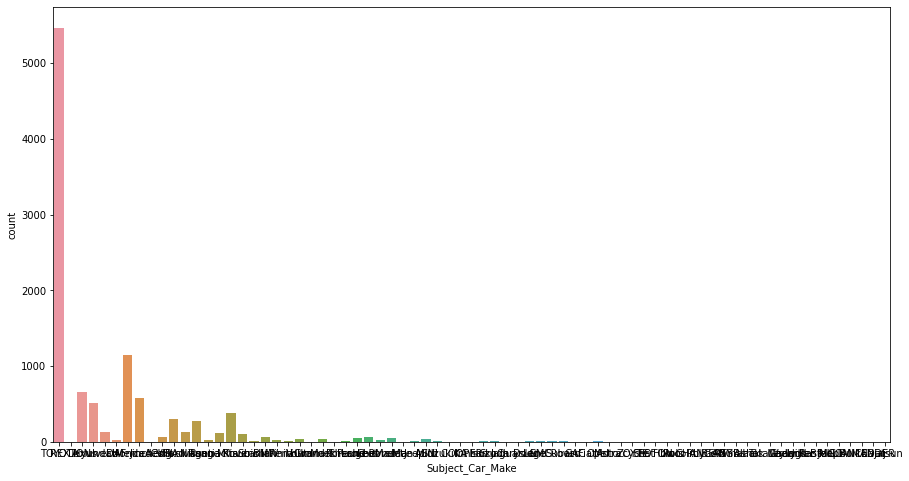

In [ ]:
plt.figure(figsize=(15,8))
sns.countplot(all_data['Subject_Car_Make'])

In [ ]:
#Fill the missing values with toyota
all_data['Subject_Car_Make'].fillna('TOYOTA', inplace=True)

In [ ]:
all_data['Subject_Car_Make'].value_counts().head(10)

TOYOTA        8251
Honda         1146
Lexus          654
Mercedes       577
Hyundai        512
Kia            375
Ford           307
Nissan         275
Volkswagen     133
Iveco          129
Name: Subject_Car_Make, dtype: int64

In [ ]:
all_data.isnull().sum()

ID                           0
Policy Start Date            0
Policy End Date              0
Gender                       0
Age                          0
First Transaction Date       0
No_Pol                       0
Car_Category              4110
Subject_Car_Colour        7659
Subject_Car_Make             0
LGA_Name                  7132
State                     7144
ProductName                  0
target                    1202
dtype: int64

#### filling null values in Car_Category

In [ ]:
all_data['Car_Category'].value_counts(ascending=True).head(30)

CAMRY CAR HIRE                1
Tipper Truck                  1
Pick Up > 3 Tons              2
Van                           3
Shape Of Vehicle Chasis       6
Station 4 Wheel               6
Wagon                        10
Mini Van                     13
Sedan                        14
Motorcycle                   18
Pick Up                      32
Mini Bus                     45
Bus                          56
Truck                       108
JEEP                       2223
Saloon                     6633
Name: Car_Category, dtype: int64

In [ ]:
#fill null values with Saloon
all_data['Car_Category'].fillna('Saloon',inplace=True)

In [ ]:
all_data.isnull().sum()

ID                           0
Policy Start Date            0
Policy End Date              0
Gender                       0
Age                          0
First Transaction Date       0
No_Pol                       0
Car_Category                 0
Subject_Car_Colour        7659
Subject_Car_Make             0
LGA_Name                  7132
State                     7144
ProductName                  0
target                    1202
dtype: int64

#### filling null values in Subject_Car_Colour

In [ ]:
all_data[["Subject_Car_Colour"]].head()

,Subject_Car_Colour
0,Black
1,Grey
2,Red
3,NaN
4,NaN


In [ ]:
all_data["Subject_Car_Colour"].value_counts().head(60)

Black             2057
Silver             605
Grey               565
As Attached        555
Blue               398
White              321
Red                274
Green              259
Gold               192
Ash                142
Wine               101
Brown               65
Cream               10
Yellow               8
Dark Gray            7
Orange               5
White & Blue         5
B.Silver             4
Purple               4
Red & White          4
Blue & Red           3
D. Red               3
Light Green          3
Dark Grey            3
Black & Orange       2
Black & White        2
Gray & Silver        2
Dark Blue            2
White & Red          2
Red & Black          2
Gray & Gray          2
Blue&White&Red       1
White & Yellow       1
Beige Mitalic        1
Blue Sky             1
Red & Yellow         1
Burgundy             1
Champagne            1
D. Gold              1
Dark Green           1
Dark Red             1
Light Blue           1
Light Gray           1
Red Maroon 

In [ ]:
all_data["Subject_Car_Colour"].replace({"As Attached":np.nan}, inplace=True)

In [ ]:
all_data.isnull().sum()

ID                           0
Policy Start Date            0
Policy End Date              0
Gender                       0
Age                          0
First Transaction Date       0
No_Pol                       0
Car_Category                 0
Subject_Car_Colour        8214
Subject_Car_Make             0
LGA_Name                  7132
State                     7144
ProductName                  0
target                    1202
dtype: int64

In [ ]:
#filling the missing values with black
all_data['Subject_Car_Colour'].fillna('Black', inplace=True)

In [ ]:
all_data.isnull().sum()

ID                           0
Policy Start Date            0
Policy End Date              0
Gender                       0
Age                          0
First Transaction Date       0
No_Pol                       0
Car_Category                 0
Subject_Car_Colour           0
Subject_Car_Make             0
LGA_Name                  7132
State                     7144
ProductName                  0
target                    1202
dtype: int64

#### filling null values in LGA_Name

In [ ]:
all_data['LGA_Name'].value_counts(ascending=True).head(60)

Ilesha               1
Katcha               1
Iwo                  1
Isoko south          1
Isoko North          1
Ilesha East          1
Ikwerre              1
Ijora                1
Ijebu North          1
Ijebu East           1
Ifako-Agege          1
Idemili south        1
IJAIYE               1
IBA                  1
Hong                 1
Garki                1
Ethiope East         1
Essien Udim          1
Eleme                1
Ekwusigo             1
Ekiti South-West     1
Eket                 1
Ekeremor             1
ENUGU SOUTH          1
EMENE                1
EFFURUN              1
Keffi                1
Kuje                 1
MAGBORO              1
Ndokwa East          1
Zaria                1
Yorro                1
Yenagoa              1
VGC                  1
Ughelli North        1
Tai                  1
Rogo                 1
QuaAn Pan            1
Palm Groove          1
Oyo West             1
Owerri North         1
Ovia SouthWest       1
Bosso                1
Oturkpo    

In [ ]:
all_data[(all_data["LGA_Name"].isnull() == False) & 
         (all_data["State"].isnull() == True)][["LGA_Name", "State"]].head(60)

,LGA_Name,State
297,LGA,NaN
568,LGA,NaN
1024,LGA,NaN
1168,LGA,NaN
1262,LGA,NaN
2544,LGA,NaN
3583,LGA,NaN
4717,LGA,NaN
7321,LGA,NaN
7608,LGA,NaN


In [ ]:
all_data[(all_data["LGA_Name"].isnull() == True) & 
         (all_data["State"].isnull() == False)][["LGA_Name", "State"]].head(60)

,LGA_Name,State
9380,NaN,N-A


In [ ]:
all_data[(all_data["LGA_Name"].isnull() == True) & 
         (all_data["State"].isnull() == False)][["LGA_Name", "State"]].head(60)

,LGA_Name,State
9380,NaN,N-A


In [ ]:
#replace N-A state with null
all_data["State"].replace({"N-A":np.nan}, inplace=True)

In [ ]:
all_data[(all_data["LGA_Name"].isnull() == False) & 
         (all_data["State"].isnull() == True)][["LGA_Name", "State"]].head(60)

,LGA_Name,State
297,LGA,NaN
568,LGA,NaN
1024,LGA,NaN
1168,LGA,NaN
1262,LGA,NaN
2544,LGA,NaN
3583,LGA,NaN
4717,LGA,NaN
7321,LGA,NaN
7608,LGA,NaN


In [ ]:
#There is no LGA_Name called LGA hence we replace with null value
all_data["LGA_Name"].replace({"LGA":np.nan}, inplace=True)

In [ ]:
all_data[(all_data["LGA_Name"].isnull() == False) & 
         (all_data["State"].isnull() == True)][["LGA_Name", "State"]].head(60)

,LGA_Name,State


In [ ]:
all_data[(all_data["LGA_Name"].isnull() == True) & 
         (all_data["State"].isnull() == True)][["LGA_Name", "State"]].head()

,LGA_Name,State
0,NaN,NaN
1,NaN,NaN
2,NaN,NaN
3,NaN,NaN
5,NaN,NaN


In [ ]:
all_data["LGA_Name"].value_counts()

Victoria Island    1284
Ikeja               438
Surulere            306
Abuja Municipal     257
Lagos Mainland      245
                   ... 
Katcha                1
Rogo                  1
Bekwara               1
Owerri North          1
Yorro                 1
Name: LGA_Name, Length: 269, dtype: int64

In [ ]:
all_data["State"].value_counts()

Lagos              3494
Benue               693
Abuja-Municipal     257
Eti-Osa             241
Ibeju-Lekki         129
                   ... 
Ijebu-North           1
Essien-Udim           1
Isoko-North           1
Bayelsa               1
Ogba-Ndoni            1
Name: State, Length: 112, dtype: int64

In [ ]:
#Fill missing values with mode
all_data["State"].fillna("Lagos",inplace=True)
all_data["LGA_Name"].fillna("Victoria Island", inplace=True)

In [ ]:
all_data[["LGA_Name","State"]].isnull().sum()

LGA_Name    0
State       0
dtype: int64

In [ ]:
#Combining the LGA_NAME and state columns
all_data["LGA_Name_State"] = all_data["LGA_Name"] + "_" + all_data["State"]
all_data[["LGA_Name_State","LGA_Name","State"]].head()

,LGA_Name_State,LGA_Name,State
0,Victoria Island_Lagos,Victoria Island,Lagos
1,Victoria Island_Lagos,Victoria Island,Lagos
2,Victoria Island_Lagos,Victoria Island,Lagos
3,Victoria Island_Lagos,Victoria Island,Lagos
4,Lagos_Lagos,Lagos,Lagos


In [ ]:
all_data["LGA_Name_State"].value_counts()

Victoria Island_Lagos              8429
Ikeja_Lagos                         438
Surulere_Lagos                      306
Abuja Municipal_Abuja-Municipal     257
Lagos Mainland_Lagos                245
                                   ... 
Hong_Benue                            1
OWODE_Benue                           1
Tai _Benue                            1
Eleme_Benue                           1
kumbotso_Benue                        1
Name: LGA_Name_State, Length: 270, dtype: int64

# Policy length dates

In [ ]:
all_data['policy_length'] = (pd.to_datetime(all_data['Policy End Date'], format='%Y-%m-%d') - 
                             pd.to_datetime(all_data['Policy Start Date'], format='%Y-%m-%d'))/ np.timedelta64(1, 'M')

In [ ]:
all_data.head()

,ID,Policy Start Date,Policy End Date,Gender,Age,First Transaction Date,No_Pol,Car_Category,Subject_Car_Colour,Subject_Car_Make,LGA_Name,State,ProductName,target,LGA_Name_State,policy_length
0,ID_0040R73,2010-05-14,2011-05-13,Male,30,2010-05-14,1,Saloon,Black,TOYOTA,Victoria Island,Lagos,Car Classic,0.0,Victoria Island_Lagos,11.959178
1,ID_0046BNK,2010-11-29,2011-11-28,Female,79,2010-11-29,1,JEEP,Grey,TOYOTA,Victoria Island,Lagos,Car Classic,1.0,Victoria Island_Lagos,11.959178
2,ID_005QMC3,2010-03-21,2011-03-20,Male,43,2010-03-21,1,Saloon,Red,TOYOTA,Victoria Island,Lagos,Car Classic,0.0,Victoria Island_Lagos,11.959178
3,ID_0079OHW,2010-08-21,2011-08-20,Male,2,2010-08-21,1,Saloon,Black,TOYOTA,Victoria Island,Lagos,CarSafe,0.0,Victoria Island_Lagos,11.959178
4,ID_00BRP63,2010-08-29,2010-12-31,Other,20,2010-08-29,3,Saloon,Black,TOYOTA,Lagos,Lagos,Muuve,1.0,Lagos_Lagos,4.074006


In [ ]:
all_data.isnull().sum()

ID                           0
Policy Start Date            0
Policy End Date              0
Gender                       0
Age                          0
First Transaction Date       0
No_Pol                       0
Car_Category                 0
Subject_Car_Colour           0
Subject_Car_Make             0
LGA_Name                     0
State                        0
ProductName                  0
target                    1202
LGA_Name_State               0
policy_length                0
dtype: int64

### Encode the Statistical Data Type

In [ ]:
all_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13281 entries, 0 to 13280
Data columns (total 16 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   ID                      13281 non-null  object        
 1   Policy Start Date       13281 non-null  datetime64[ns]
 2   Policy End Date         13281 non-null  datetime64[ns]
 3   Gender                  13281 non-null  object        
 4   Age                     13281 non-null  int64         
 5   First Transaction Date  13281 non-null  datetime64[ns]
 6   No_Pol                  13281 non-null  int64         
 7   Car_Category            13281 non-null  category      
 8   Subject_Car_Colour      13281 non-null  object        
 9   Subject_Car_Make        13281 non-null  object        
 10  LGA_Name                13281 non-null  object        
 11  State                   13281 non-null  object        
 12  ProductName             13281 non-null  catego

In [ ]:
#Changing each column to appropriate datatype
date_cols = [col for col in all_data.columns if 'Date' in col]
num_cols = ['Age', 'No_Pol', 'policy_length']
cat_cols = [col for col in all_data.columns if col not in date_cols+num_cols+['ID','target']]

for col in all_data.columns:
  if col in date_cols:
    all_data[col] = pd.to_datetime(all_data[col])
  elif col in cat_cols:
    all_data[col] = all_data[col].astype('category')

#Confirming wether the changes have been applied
all_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13281 entries, 0 to 13280
Data columns (total 16 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   ID                      13281 non-null  object        
 1   Policy Start Date       13281 non-null  datetime64[ns]
 2   Policy End Date         13281 non-null  datetime64[ns]
 3   Gender                  13281 non-null  category      
 4   Age                     13281 non-null  int64         
 5   First Transaction Date  13281 non-null  datetime64[ns]
 6   No_Pol                  13281 non-null  int64         
 7   Car_Category            13281 non-null  category      
 8   Subject_Car_Colour      13281 non-null  category      
 9   Subject_Car_Make        13281 non-null  category      
 10  LGA_Name                13281 non-null  category      
 11  State                   13281 non-null  category      
 12  ProductName             13281 non-null  catego

In [ ]:
#The nominative (unordered) categorical features
features_nom = ["Gender", "Car_Category", "Subject_Car_Colour", "Subject_Car_Make", "ProductName","LGA_Name_State"]

In [ ]:
from pandas.api.types import CategoricalDtype

for name in features_nom:
    all_data[name] = all_data[name].astype(CategoricalDtype())

In [ ]:
all_data.head()

,ID,Policy Start Date,Policy End Date,Gender,Age,First Transaction Date,No_Pol,Car_Category,Subject_Car_Colour,Subject_Car_Make,LGA_Name,State,ProductName,target,LGA_Name_State,policy_length
0,ID_0040R73,2010-05-14,2011-05-13,Male,30,2010-05-14,1,Saloon,Black,TOYOTA,Victoria Island,Lagos,Car Classic,0.0,Victoria Island_Lagos,11.959178
1,ID_0046BNK,2010-11-29,2011-11-28,Female,79,2010-11-29,1,JEEP,Grey,TOYOTA,Victoria Island,Lagos,Car Classic,1.0,Victoria Island_Lagos,11.959178
2,ID_005QMC3,2010-03-21,2011-03-20,Male,43,2010-03-21,1,Saloon,Red,TOYOTA,Victoria Island,Lagos,Car Classic,0.0,Victoria Island_Lagos,11.959178
3,ID_0079OHW,2010-08-21,2011-08-20,Male,2,2010-08-21,1,Saloon,Black,TOYOTA,Victoria Island,Lagos,CarSafe,0.0,Victoria Island_Lagos,11.959178
4,ID_00BRP63,2010-08-29,2010-12-31,Other,20,2010-08-29,3,Saloon,Black,TOYOTA,Lagos,Lagos,Muuve,1.0,Lagos_Lagos,4.074006


## Establish Baseline

In [ ]:
# Separate train and test data from the combined dataframe
train_df = all_data[:ntrain]
test_df = all_data[ntrain:]

# Check the shapes of the split dataset
train_df.shape, test_df.shape

((12079, 16), (1202, 16))

In [ ]:
# Select main columns to be used in training
main_cols = all_data.columns.difference(['ID', 'target', 'Policy Start Date', 'Policy End Date',
                                          'First Transaction Date','LGA_Name', 'State'])


X = train_df[main_cols]
y = train_df.target

for colname in X.select_dtypes(["category"]):
    X[colname] = X[colname].cat.codes


# Standardize
#X_scaled = (X - X.mean(axis=0)) / X.std(axis=0)

#from sklearn.decomposition import PCA

# Create principal components
#pca = PCA()
#X_pca = pca.fit_transform(X)

# Convert to dataframe
#component_names = [f"PC{i+1}" for i in range(X_pca.shape[1])]
#X_pca = pd.DataFrame(X_pca, columns=component_names)

#X_pca.head()

# Split data into train and test sets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.25, random_state=42)

### LGBMClassifier

F1 score on the X_test is: 0.16630196936542668


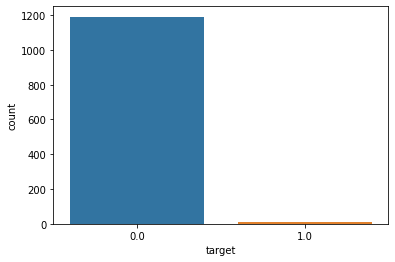

In [ ]:
# Train model
model_lgbm = LGBMClassifier()
model_lgbm.fit(X_train, y_train)

# Make predictions
y_pred = model_lgbm.predict(X_test)

# Check the f1 score of the model
print(f'F1 score on the X_test is: {f1_score(y_test, y_pred)}')

# Make prediction on the test set
test_df = test_df[main_cols]
for colname in test_df.select_dtypes(["category"]):
    test_df[colname] = test_df[colname].cat.codes

predictions = model_lgbm.predict(test_df)

# Create a submission file
sub_file = ss.copy()
sub_file.target = predictions

# Check the distribution of your predictions
sns.countplot(sub_file.target)

# Create a csv file and upload to zindi 
sub_file.to_csv('lgbm_02.csv', index = False)

### RandomForestClassifier

F1 score on the X_test is: 0.2356687898089172


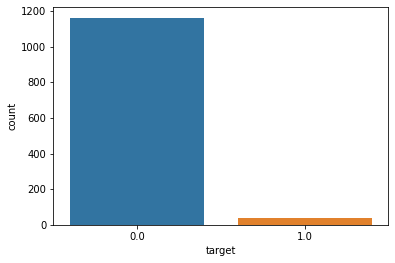

In [ ]:
# Train model
from sklearn.ensemble import RandomForestClassifier
model_ranforest = RandomForestClassifier(random_state=42)
model_ranforest.fit(X_train, y_train)

# Make predictions
y_pred = model_ranforest.predict(X_test)

# Check the f1 score of the model
print(f'F1 score on the X_test is: {f1_score(y_test, y_pred)}')

# Make prediction on the test set
test_df = test_df[main_cols]
for colname in test_df.select_dtypes(["category"]):
    test_df[colname] = test_df[colname].cat.codes

predictions = model_ranforest.predict(test_df)

# Create a submission file
sub_file = ss.copy()
sub_file.target = predictions

# Check the distribution of your predictions
sns.countplot(sub_file.target)

# Create a csv file and upload to zindi 
sub_file.to_csv('ranforest_00006.csv', index = False)

#### Random Hyperparameter Grid

In [ ]:
from sklearn.model_selection import RandomizedSearchCV

# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
               
print(random_grid)

{'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000], 'max_features': ['auto', 'sqrt'], 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4], 'bootstrap': [True, False]}


In [ ]:
# Use the random grid to search for best hyperparameters
# First create the base model to tune
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier()
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)
# Fit the random search model
rf_random.fit(X_train, y_train)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:  3.1min
[Parallel(n_jobs=-1)]: Done 158 tasks      | elapsed: 13.5min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed: 24.9min finished


RandomizedSearchCV(cv=3, error_score=nan,
                   estimator=RandomForestClassifier(bootstrap=True,
                                                    ccp_alpha=0.0,
                                                    class_weight=None,
                                                    criterion='gini',
                                                    max_depth=None,
                                                    max_features='auto',
                                                    max_leaf_nodes=None,
                                                    max_samples=None,
                                                    min_impurity_decrease=0.0,
                                                    min_impurity_split=None,
                                                    min_samples_leaf=1,
                                                    min_samples_split=2,
                                                    min_weight_fraction_leaf=0.0,
               

In [ ]:
rf_random.best_params_

{'bootstrap': True,
 'max_depth': 10,
 'max_features': 'sqrt',
 'min_samples_leaf': 4,
 'min_samples_split': 2,
 'n_estimators': 1600}

F1 score on the X_test is: 0.11594202898550723


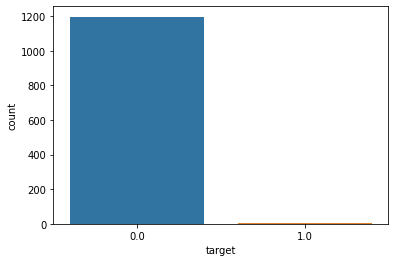

In [ ]:
# Train model
from sklearn.ensemble import RandomForestClassifier
model_ranforest = RandomForestClassifier(bootstrap = True,
                                         max_depth = 10,
                                         max_features = 'sqrt',
                                         min_samples_leaf = 4,
                                         min_samples_split = 2,
                                         n_estimators = 1600,
                                         random_state=42)
model_ranforest.fit(X_train, y_train)

# Make predictions
y_pred = model_ranforest.predict(X_test)

# Check the f1 score of the model
print(f'F1 score on the X_test is: {f1_score(y_test, y_pred)}')

# Make prediction on the test set
test_df = test_df[main_cols]
for colname in test_df.select_dtypes(["category"]):
    test_df[colname] = test_df[colname].cat.codes

predictions = model_ranforest.predict(test_df)

# Create a submission file
sub_file = ss.copy()
sub_file.target = predictions

# Check the distribution of your predictions
sns.countplot(sub_file.target)

# Create a csv file and upload to zindi 
sub_file.to_csv('ranforest_000010.csv', index = False)

In [ ]:
from sklearn.model_selection import GridSearchCV
# Create the parameter grid based on the results of random search 
param_grid = {
    'bootstrap': [True],
    'max_depth': [80, 90, 100, 110],
    'max_features': [2, 3],
    'min_samples_leaf': [3, 4, 5],
    'min_samples_split': [8, 10, 12],
    'n_estimators': [100, 200, 300, 1000]
}
# Create a based model
rf = RandomForestClassifier()
# Instantiate the grid search model
grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, 
                          cv = 3, n_jobs = -1, verbose = 2)

In [ ]:
# Fit the grid search to the data
grid_search.fit(X_train, y_train)

grid_search.best_params_

Fitting 3 folds for each of 288 candidates, totalling 864 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   48.4s
[Parallel(n_jobs=-1)]: Done 158 tasks      | elapsed:  3.6min
[Parallel(n_jobs=-1)]: Done 361 tasks      | elapsed:  8.4min
[Parallel(n_jobs=-1)]: Done 644 tasks      | elapsed: 15.2min
[Parallel(n_jobs=-1)]: Done 864 out of 864 | elapsed: 20.6min finished


{'bootstrap': True,
 'max_depth': 90,
 'max_features': 2,
 'min_samples_leaf': 4,
 'min_samples_split': 8,
 'n_estimators': 1000}

F1 score on the X_test is: 0.11165048543689321


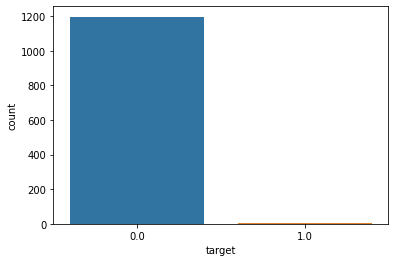

In [ ]:
# Train model
from sklearn.ensemble import RandomForestClassifier
model_ranforest = RandomForestClassifier(bootstrap = True,
                                         max_depth = 90,
                                         max_features = 2,
                                         min_samples_leaf = 4,
                                         min_samples_split = 8,
                                         n_estimators = 1000)
model_ranforest.fit(X_train, y_train)

# Make predictions
y_pred = model_ranforest.predict(X_test)

# Check the f1 score of the model
print(f'F1 score on the X_test is: {f1_score(y_test, y_pred)}')

# Make prediction on the test set
test_df = test_df[main_cols]
for colname in test_df.select_dtypes(["category"]):
    test_df[colname] = test_df[colname].cat.codes

predictions = model_ranforest.predict(test_df)

# Create a submission file
sub_file = ss.copy()
sub_file.target = predictions

# Check the distribution of your predictions
sns.countplot(sub_file.target)

# Create a csv file and upload to zindi 
sub_file.to_csv('ranforest_000011.csv', index = False)

### DecisionTreeClassifier

F1 score on the X_test is: 0.22972972972972974


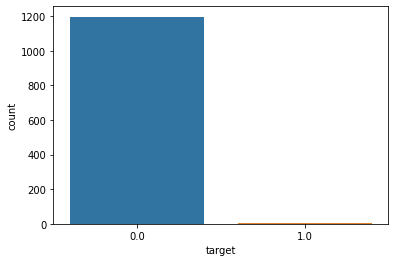

In [ ]:
# Train model
from sklearn.tree import DecisionTreeClassifier
model_decision_tree = DecisionTreeClassifier()
model_decision_tree.fit(X_train, y_train)

# Make predictions
y_pred = model_decision_tree.predict(X_test)

# Check the f1 score of the model
print(f'F1 score on the X_test is: {f1_score(y_test, y_pred)}')

# Make prediction on the test set
test_df = test_df[main_cols]
for colname in test_df.select_dtypes(["category"]):
    test_df[colname] = test_df[colname].cat.codes

predictions = model_ranforest.predict(test_df)

# Create a submission file
sub_file = ss.copy()
sub_file.target = predictions

# Check the distribution of your predictions
sns.countplot(sub_file.target)

# Create a csv file and upload to zindi 
sub_file.to_csv('decision_tree_0001.csv', index = False)

# Step 4 - Hyperparameter Tuning
